In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import add_messages
from langgraph.checkpoint.memory import MemorySaver
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_core.messages import ToolMessage
from typing import Annotated

In [2]:
load_dotenv()

True

In [3]:
# server_params = StdioServerParameters(
#     command="python",
#     args = ["/Users/lakshitagarwal/Hivel/mcp-server/pr_mcp_server.py"],
#     env = None
# )
# async def init_mcp():
#     """Initialize MCP connection and load tools"""
#     async with stdio_client(server_params) as (read, write):
#         async with ClientSession(read, write) as session:
#             await session.initialize()
#             tools = await load_mcp_tools(session)
#             return tools

In [4]:
server_params = StdioServerParameters(
    command="python",
    args=["/Users/lakshitagarwal/Hivel/mcp-server/pr_mcp_server.py"], 
    env=None
)

mcp_client = None
mcp_session = None
mcp_tools = None

async def init_mcp():
    """Initialize MCP connection and load tools"""
    global mcp_client, mcp_session, mcp_tools
    
    # Create client
    mcp_client = stdio_client(server_params)
    read, write = await mcp_client.__aenter__()
    
    # Create session
    mcp_session = ClientSession(read, write)
    await mcp_session.__aenter__()
    await mcp_session.initialize()
    
    # Load tools
    mcp_tools = await load_mcp_tools(mcp_session)
    for tool in mcp_tools:
        print(tool.name)
    
    return mcp_tools

tools = await init_mcp()


run_query
get_pr_summary
list_tables
safe_sql


In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [6]:
# state
class chatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
# func
def chat_node(state: chatState) -> chatState:
    messages = state["messages"]
    res = llm_with_tools.invoke(messages)
    return {"messages": [res]}

async def tool_node(state: chatState) -> chatState:
    """Execute any tool calls from the last message"""
    last_message = state["messages"][-1]
    
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return {"messages": []}
    
    tool_messages = []
    for tool_call in last_message.tool_calls:
        # Find the matching tool
        matching_tool = None
        for tool in tools:
            if tool.name == tool_call["name"]:
                matching_tool = tool
                break
        
        if matching_tool:
                result = await matching_tool.ainvoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=str(result),
                        tool_call_id=tool_call["id"]
                    )
                )
        else:
            # Tool not found - still need to respond to maintain message flow
            tool_messages.append(
                ToolMessage(
                    content=f"Error: Tool '{tool_call['name']}' not found",
                    tool_call_id=tool_call["id"]
                )
            )
    return {"messages": tool_messages}

def should_continue(state: chatState) -> str:
    """Decide: continue to tools or end?"""
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    return "end"



In [8]:
checkptr = MemorySaver()

graph = StateGraph(chatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges(
    "chat_node",
    should_continue,
    {
        "tools": "tools",
        "end": END
    })
graph.add_edge("tools", "chat_node")

workflow = graph.compile(checkpointer=checkptr)

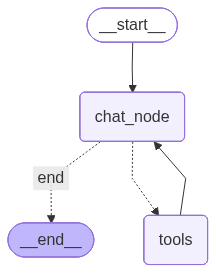

In [9]:
workflow

In [10]:
# intial_state = {"messages": [HumanMessage(content="Hello, how are you?")]}
# workflow.invoke(intial_state)["messages"][-1].content

In [15]:
thread_id = '5'

while True:
    user_inp = input("You: ")
    if user_inp in ["exit", "bye", "quit"]:
        break

    config = {"configurable": {"thread_id": thread_id}}
    res = await workflow.ainvoke({"messages": [HumanMessage(content=user_inp)]}, config=config)
    print(f"LLM: {res['messages'][-1].content}")


LLM: You asked me to tell you the five tables with the most rows in your database. If you have any further questions or need more assistance, feel free to ask!
LLM: Here are the five tables with the most rows in your database:

1. **task_alerts**: 1,220,441 rows
2. **pull_request**: 92,041 rows
3. **webhook_process_logs**: 96,165 rows
4. **pr_update**: 19,764 rows
5. **pr_commit_relation**: 12,505 rows

If you need more details or assistance, let me know!
LLM: Here are the column counts for each of the five tables:

1. **task_alerts**: 5 columns
2. **pull_request**: 75 columns
3. **webhook_process_logs**: 10 columns
4. **pr_update**: 15 columns
5. **pr_commit_relation**: 7 columns

Among these, the **pull_request** table has the most columns with a total of 75 columns. If you need any further information, just let me know!


ToolException: Error executing tool run_query: relation "pull_request" does not exist
LINE 1: ...CT author_id, COUNT(*) as pull_request_count FROM pull_reque...
                                                             ^
